In [1]:
!pip install pmdarima

In [85]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import warnings

In [86]:
from math import sqrt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [196]:
warnings.filterwarnings("ignore")

In [233]:
df = pd.read_csv('../data/sensor1.csv')

In [234]:
df = df.dropna()

In [235]:
units_dict = {}

for col in df.columns[1:]:
    values = []
    units = set()
    for val in df[col]:
        value, unit = val.split()
        values.append(value)
        units.add(unit)
    new_col_name = f"{col} ({units.pop()})"
    df.rename(columns={col: new_col_name}, inplace=True)
    df[new_col_name] = pd.to_numeric(values)
    units_dict[col] = units

In [236]:
df['Time'] = pd.to_datetime(df['Time'])

In [237]:
df.index = df['Time']
df.drop(columns=['Time'], inplace=True)

In [238]:
df = df.sort_index()

In [239]:
co2 = df["CO2 (ppm)"]

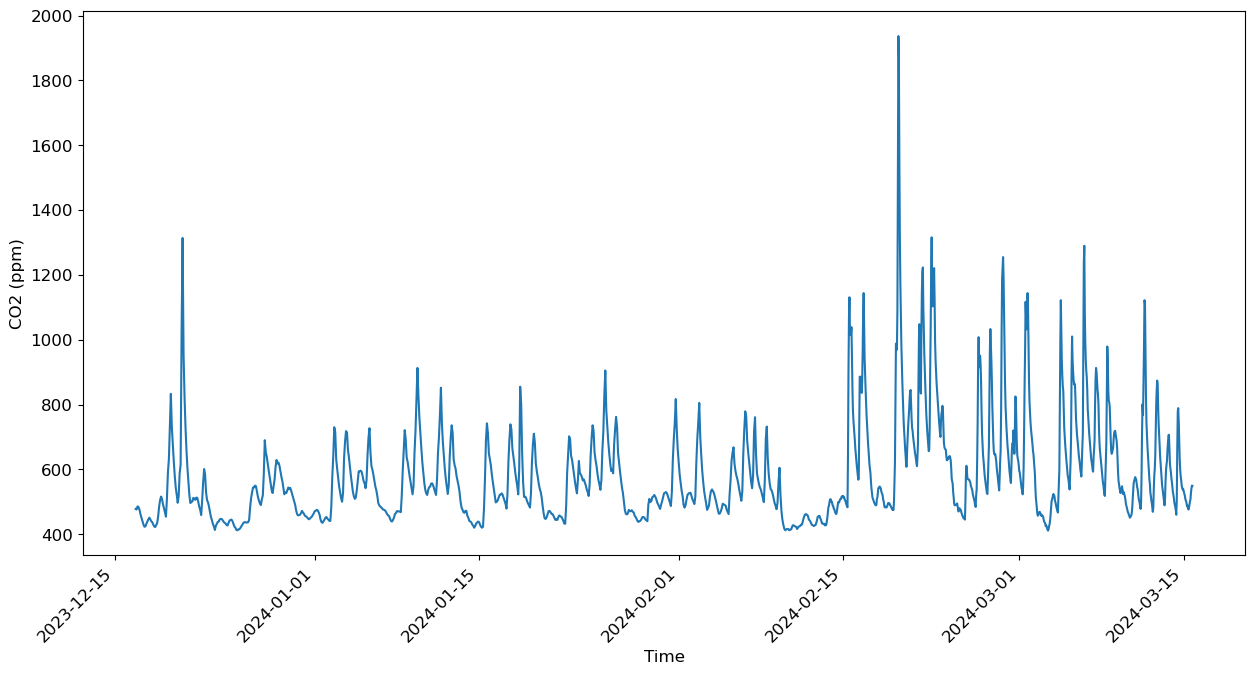

In [240]:
co2.plot(y='CO2 (ppm)', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.ylabel('CO2 (ppm)', fontsize=12)
plt.xticks(rotation=45)
plt.show()

Create training and testing datasets

In [241]:
train_size = int(0.8 * len(df))

In [242]:
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

In [243]:
train_start_dt = train_df.index[0]
test_start_dt = test_df.index[0]

In [244]:
train_start_dt, test_start_dt

(Timestamp('2023-12-16 18:00:00'), Timestamp('2024-03-03 14:00:00'))

In [245]:
df

CO2 (ppm)  Humidity (%H)  PM10 (μg/m³)  PM2.5 (μg/m³)  \
Time                                                                         
2023-12-16 18:00:00        478           81.1          10.3           9.75   
2023-12-16 20:00:00        476           80.7          10.0           9.88   
2023-12-16 22:00:00        486           80.5          11.1          10.50   
2023-12-17 00:00:00        483           80.5          12.2          11.70   
2023-12-17 02:00:00        475           80.5          13.1          12.40   
...                        ...            ...           ...            ...   
2024-03-15 14:00:00        508           78.6          20.2          19.20   
2024-03-15 15:00:00        528           78.6          19.2          18.50   
2024-03-15 16:00:00        542           78.8          18.8          18.30   
2024-03-15 17:00:00        550           78.5          23.0          20.00   
2024-03-15 18:00:00        549           79.0          20.0          19.30   

                     Temperature (°C)  TVOC (ppm)  
Time                                               
2023-12-16 18:00:00              23.2       0.755  
2023-12-16 20:00:00              23.5       0.783  
2023-12-16 22:00:00              23.6       0.777  
2023-12-17 00:00:00              23.7       0.831  
2023-12-17 02:00:00              23.7       0.846  
...                               ...         ...  
2024-03-15 14:00:00              23.3       0.475  
2024-03-15 15:00:00              23.3       0.500  
2024-03-15 16:00:00              23.3       0.500  
2024-03-15 17:00:00              23.2       0.560  
2024-03-15 18:00:00              23.1       0.497  

[1462 rows x 6 columns]

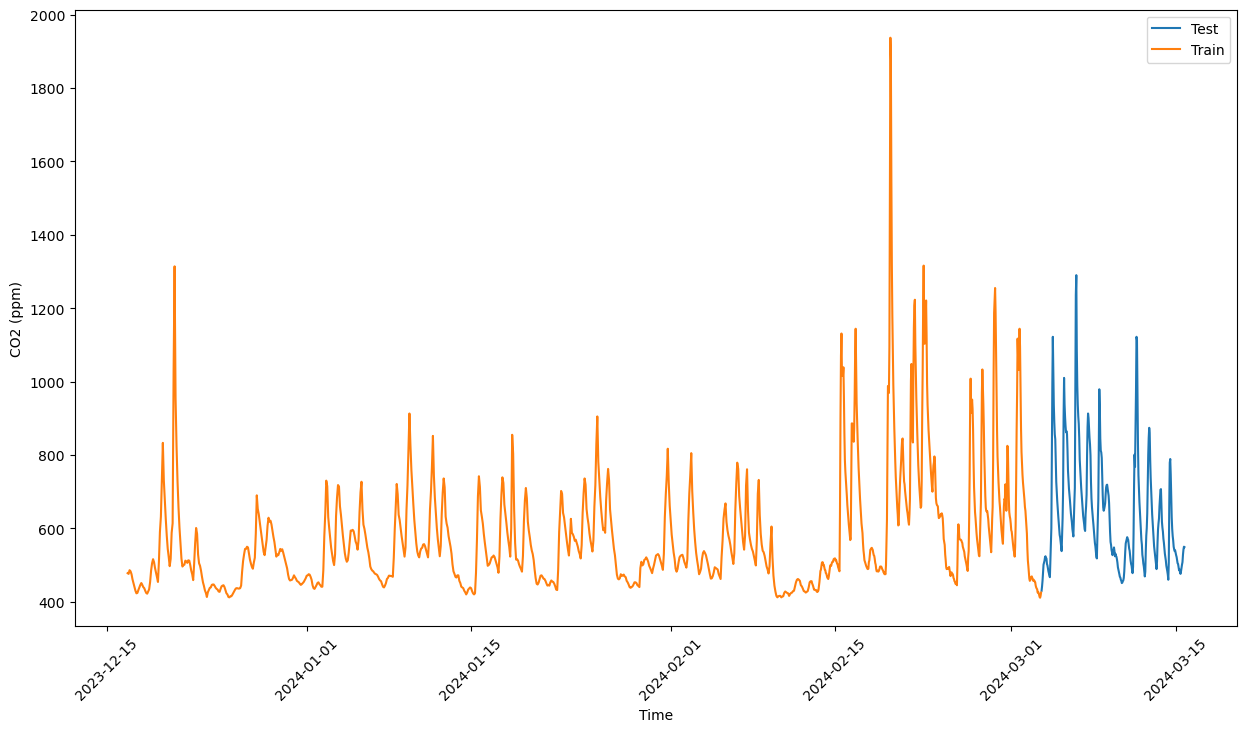

In [246]:
test_co2 = df[df.index >= test_start_dt]["CO2 (ppm)"]
train_co2 = df[(df.index < test_start_dt) & (df.index >= train_start_dt)]["CO2 (ppm)"]

plt.figure(figsize=(15, 8))
plt.plot(test_co2.index, test_co2.values, label='Test')

plt.plot(train_co2.index, train_co2.values, label='Train')

plt.xlabel('Time')
plt.ylabel('CO2 (ppm)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Data preparation

In [247]:
train_co2_reshaped = train_co2.values.reshape(-1, 1)
test_co2_reshaped = test_co2.values.reshape(-1, 1)

In [248]:
print("Training data shape: ", train_co2_reshaped.shape)
print("Test data shape: ", test_co2_reshaped.shape)

Training data shape:  (1169, 1)
Test data shape:  (293, 1)


In [249]:
scaler = MinMaxScaler()
train_co2_scaled = scaler.fit_transform(train_co2_reshaped)
train_co2_scaled = pd.DataFrame(train_co2_scaled.flatten(), index=train_co2.index, columns=["CO2 (ppm)"])
train_co2_scaled.head(10)

CO2 (ppm)
Time                          
2023-12-16 18:00:00   0.043906
2023-12-16 20:00:00   0.042595
2023-12-16 22:00:00   0.049148
2023-12-17 00:00:00   0.047182
2023-12-17 02:00:00   0.041940
2023-12-17 04:00:00   0.032765
2023-12-17 06:00:00   0.026212
2023-12-17 08:00:00   0.020315
2023-12-17 10:00:00   0.012451
2023-12-17 12:00:00   0.007864

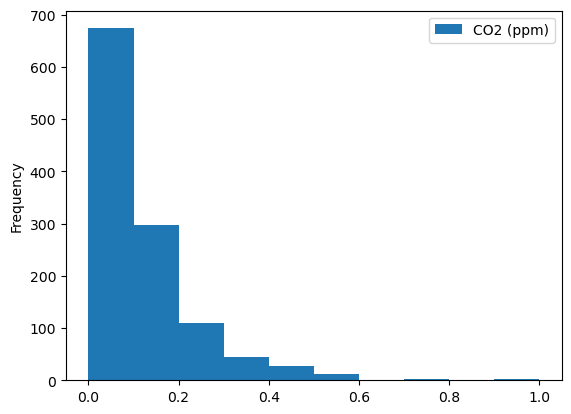

In [250]:
train_co2_scaled.plot.hist(bins=10)
plt.show()

In [251]:
test_co2_scaled = scaler.fit_transform(test_co2_reshaped)
test_co2_scaled = pd.DataFrame(test_co2_scaled.flatten(), index=test_co2.index, columns=["CO2 (ppm)"])
test_co2_scaled.head(10)

CO2 (ppm)
Time                          
2024-03-03 14:00:00   0.000000
2024-03-03 15:00:00   0.013953
2024-03-03 16:00:00   0.032558
2024-03-03 17:00:00   0.055814
2024-03-03 18:00:00   0.082558
2024-03-03 19:00:00   0.089535
2024-03-03 20:00:00   0.095349
2024-03-03 21:00:00   0.105814
2024-03-03 22:00:00   0.109302
2024-03-03 23:00:00   0.101163

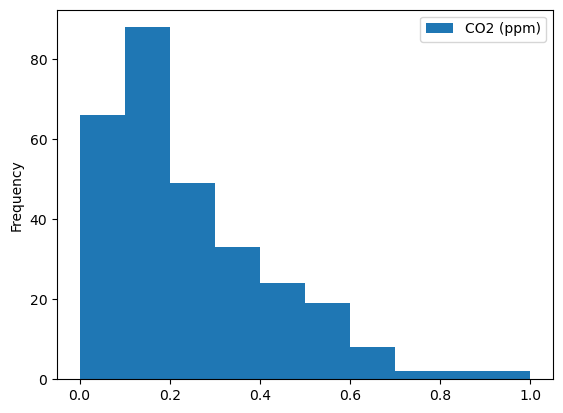

In [252]:
test_co2_scaled.plot.hist(bins=10)
plt.show()

In [253]:
HORIZON_CO2 = 1

In [254]:
stepwise_fit_co2 = auto_arima(train_co2_scaled, trace=True, suppress_warnings=True)
stepwise_fit_co2.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5131.794, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4570.348, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4970.441, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5080.516, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4572.347, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5092.350, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5092.352, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-5106.777, Time=0.30 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-5132.998, Time=0.37 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-5104.741, Time=0.26 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-5146.785, Time=0.43 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-5100.974, Time=0.56 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=-5084.179, Time=0.65 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-5137.532, Time=0.47 sec
 ARIMA(4,1,2)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1169
Model:               SARIMAX(1, 1, 4)   Log Likelihood                2587.276
Date:                Fri, 15 Mar 2024   AIC                          -5162.553
Time:                        18:41:56   BIC                          -5132.175
Sample:                             0   HQIC                         -5151.094
                               - 1169                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8455      0.017     49.270      0.000       0.812       0.879
ma.L1         -0.1463      0.020     -7.466      0.000      -0.185      -0.108
ma.L2         -0.5249      0.017    -31.770      0.000      -0.557      -0.493
ma.L3         -0.1456      0.014    -10.421      0.000      -0.173      -0.118
ma.L4         -0.1538      0.022     -7.099      0.000      -0.196      -0.111
sigma2         0.0007   7.95e-06     86.960      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):             44799.59
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               1.53   Skew:                             1.90
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [255]:
order_co2 = (1,1,4)

In [256]:
model_temp =  ARIMA(endog=train_co2_scaled, order=order_co2)
result_temp = model_temp.fit()

print(result_temp.summary())

                               SARIMAX Results                                
Dep. Variable:              CO2 (ppm)   No. Observations:                 1169
Model:                 ARIMA(1, 1, 4)   Log Likelihood                2587.276
Date:                Fri, 15 Mar 2024   AIC                          -5162.553
Time:                        18:42:06   BIC                          -5132.175
Sample:                             0   HQIC                         -5151.094
                               - 1169                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8455      0.017     49.270      0.000       0.812       0.879
ma.L1         -0.1463      0.020     -7.466      0.000      -0.185      -0.108
ma.L2         -0.5249      0.017    -31.770      0.0

Walk-forward validation

Create a test data point for each HORIZON.<br>
Shift the data horizontally according to its horizon point.

In [257]:
test_co2_shifted = test_co2_scaled.copy()

for t in range(1, HORIZON_CO2):
    test_co2_shifted["CO2 (ppm)+" + str(t)] = test_co2_shifted["CO2 (ppm)"].shift(-t, freq='H')
    
test_co2_shifted = test_co2_shifted.dropna(how='any')
test_co2_shifted.head()

CO2 (ppm)
Time                          
2024-03-03 14:00:00   0.000000
2024-03-03 15:00:00   0.013953
2024-03-03 16:00:00   0.032558
2024-03-03 17:00:00   0.055814
2024-03-03 18:00:00   0.082558

Make predictions on the test data using a sliding window approach in a loop the size of the test data length.

In [258]:
stepwise_fit_co2_test = auto_arima(test_co2_scaled, trace=True, suppress_warnings=True)
stepwise_fit_co2_test.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1017.137, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-812.391, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-962.529, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-983.566, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-814.373, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1018.587, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1020.553, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1018.597, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1011.364, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1016.588, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-1022.545, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-985.555, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-1020.580, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-1020.590, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  293
Model:               SARIMAX(0, 1, 2)   Log Likelihood                 514.273
Date:                Fri, 15 Mar 2024   AIC                          -1022.545
Time:                        18:42:11   BIC                          -1011.515
Sample:                    03-03-2024   HQIC                         -1018.127
                         - 03-15-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9529      0.037     25.412      0.000       0.879       1.026
ma.L2          0.3966      0.036     10.906      0.000       0.325       0.468
sigma2         0.0017   5.61e-05     30.730      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1734.57
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                             1.56
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [259]:
test_co2_shifted

CO2 (ppm)
Time                          
2024-03-03 14:00:00   0.000000
2024-03-03 15:00:00   0.013953
2024-03-03 16:00:00   0.032558
2024-03-03 17:00:00   0.055814
2024-03-03 18:00:00   0.082558
...                        ...
2024-03-15 14:00:00   0.090698
2024-03-15 15:00:00   0.113953
2024-03-15 16:00:00   0.130233
2024-03-15 17:00:00   0.139535
2024-03-15 18:00:00   0.138372

[293 rows x 1 columns]

In [269]:
%%time
training_window = 168

train_ts_co2 = train_co2_scaled["CO2 (ppm)"]
test_ts_co2 = test_co2_shifted

history_co2 = [x for x in train_ts_co2]
history_co2 = history_co2[(-training_window):]

predictions_co2 = list()

# order = (0,1,2)

for t in range(test_ts_co2.shape[0]):
    model_co2 = ARIMA(endog=history_co2, order=order_co2)
    model_fit_co2 = model_co2.fit()
    yhat = model_fit_co2.forecast(steps = HORIZON_CO2)
    predictions_co2.append(yhat)
    obs = list(test_ts_co2.iloc[t])
    # move the training window
    history_co2.append(obs[0])
    history_co2.pop(0)
    print(test_ts_co2.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)

2024-03-03 14:00:00
1 : predicted = [0.01786998] expected = [0.0]
2024-03-03 15:00:00
2 : predicted = [-0.00747538] expected = [0.013953488372092981]
2024-03-03 16:00:00
3 : predicted = [0.03579977] expected = [0.032558139534883734]
2024-03-03 17:00:00
4 : predicted = [0.04290872] expected = [0.05581395348837204]
2024-03-03 18:00:00
5 : predicted = [0.07676979] expected = [0.08255813953488367]
2024-03-03 19:00:00
6 : predicted = [0.0991463] expected = [0.08953488372093021]
2024-03-03 20:00:00
7 : predicted = [0.08833884] expected = [0.09534883720930232]
2024-03-03 21:00:00
8 : predicted = [0.09958513] expected = [0.10581395348837208]
2024-03-03 22:00:00
9 : predicted = [0.11329472] expected = [0.1093023255813953]
2024-03-03 23:00:00
10 : predicted = [0.11107822] expected = [0.10116279069767442]
2024-03-04 00:00:00
11 : predicted = [0.09480176] expected = [0.10232558139534886]
2024-03-04 01:00:00
12 : predicted = [0.10896354] expected = [0.08488372093023255]
2024-03-04 02:00:00
13 : pre

Compare the prediction against the actual CO2.

In [270]:
eval_df_co2 = pd.DataFrame(predictions_co2, columns=['t+'+str(t) for t in range(1, HORIZON_CO2+1)])
eval_df_co2['Time'] = test_co2_scaled.index[0:len(test_co2_scaled.index)-HORIZON_CO2+1]
eval_df_co2 = pd.melt(eval_df_co2, id_vars='Time', value_name='Prediction', var_name='H')
eval_df_co2['Actual'] = np.array(np.transpose(test_ts_co2)).ravel()
eval_df_co2[['Prediction', 'Actual']] = scaler.inverse_transform(eval_df_co2[['Prediction', 'Actual']])
eval_df_co2.head()

Time    H  Prediction  Actual
0 2024-03-03 14:00:00  t+1  445.368185   430.0
1 2024-03-03 15:00:00  t+1  423.571176   442.0
2 2024-03-03 16:00:00  t+1  460.787806   458.0
3 2024-03-03 17:00:00  t+1  466.901497   478.0
4 2024-03-03 18:00:00  t+1  496.022023   501.0

Check the model accuracy by testing its mean absolute percentage error (MAPE) over all the predictions.

In [271]:
if (HORIZON_CO2 > 1):
    eval_df_co2['APE'] = (eval_df_co2['Prediction'] - eval_df_co2['Actual']).abs()
    print(eval_df_co2.groupby('H')['APE'].mean())

In [272]:
# Mean absolute percentage error
def mape(predictions, actuals):
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    return (np.absolute(predictions - actuals) / actuals).mean()

In [273]:
print('Multi-step forecast MAPE: ', mape(eval_df_co2['Prediction'], eval_df_co2['Actual'])*100, '%')

Multi-step forecast MAPE:  2.8192714900511144 %


In [274]:
rmse_co2 = sqrt(mean_squared_error(eval_df_co2['Prediction'], eval_df_co2['Actual']))
rmse_co2

38.00103017946363

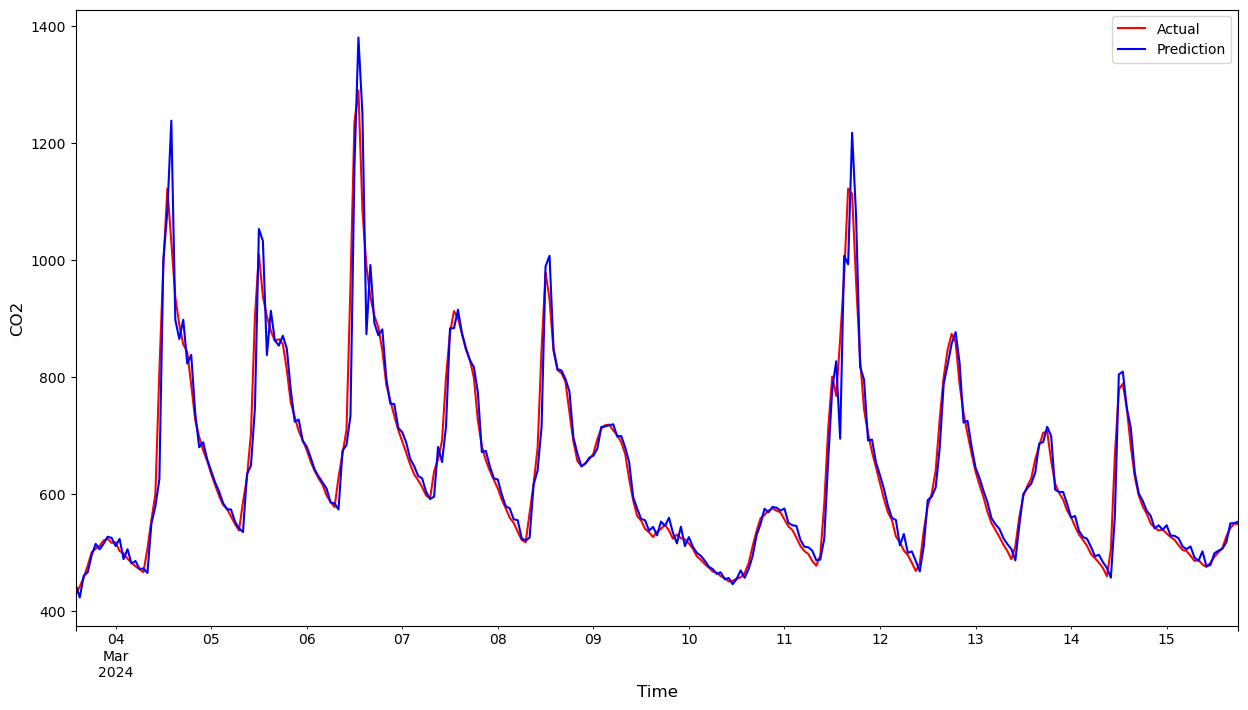

In [275]:
if HORIZON_CO2 == 1:
    eval_df_co2.plot(x='Time', y=['Actual', 'Prediction'], style=['r', 'b'], figsize=(15, 8))
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('CO2', fontsize=12)
    plt.legend(['Actual', 'Prediction'], loc='best')
    plt.show()
else:
    plot_df_co2 = eval_df_co2[(eval_df_co2.H == 't+1')][['Time', 'Actual']]
    for t in range(1, HORIZON_CO2 + 1):
        plot_df_co2['t+' + str(t)] = eval_df_co2[(eval_df_co2.H == 't+' + str(t))]['Prediction'].values

    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    ax.plot(plot_df_co2['Time'], plot_df_co2['Actual'], color='red', linewidth=4.0, label='Actual')
    for t in range(1, HORIZON_CO2 + 1):
        x = plot_df_co2['Time'][(t - 1):]
        y = plot_df_co2['t+' + str(t)][0:len(x)]
        ax.plot(x, y, color='blue', linewidth=4 * math.pow(.9, t), alpha=math.pow(0.8, t),
                label='Prediction t+' + str(t))

    ax.legend(loc='best')
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('CO2', fontsize=12)
    plt.show()

In [276]:
next_hour = pd.date_range(start=df.index[-1], periods=2, freq='H')[-1]

In [277]:
pred_co2 = model_fit_co2.predict(start=len(df), end=len(df), typ="levels")[0]
pred_co2_nonscaled = round(scaler.inverse_transform(np.array(pred_co2).reshape(-1, 1))[0][0], 1)
print(f"{next_hour} {pred_co2_nonscaled}")

2024-03-15 19:00:00 591.2
